## Load Libraries

In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # subplots
import seaborn as sns 

#Import models from scikit learn module:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn import metrics 

## Load Data 

In [4]:
df = pd.read_csv("BGG100.csv",header = 0, encoding= 'unicode_escape', index_col='Rank')

In [28]:
df.head()

,Rating,Name,Subtitle,Year,MinPlayers,MaxPlayers,BestPlayers,MinPlayTime,MaxPlayTime,MinAge,Weight,Type
Rank,,,,,,,,,,,,
1,8.511,Gloomhaven,Vanquish monsters with strategic cardplay. Ful...,2017,1,4,3,60,120,14,3.87,"Strategy, Thematic"
2,8.442,Pandemic Legacy: Season 1,Mutating diseases are spreading around the wor...,2015,2,4,4,60,60,13,2.83,"Strategy, Thematic"
3,8.418,Brass: Birmingham,"Build networks, grow industries, and navigate ...",2018,2,4,"3, 4",60,120,14,3.90,Strategy
4,8.273,Terraforming Mars,Compete with rival CEOs to make Mars habitable...,2016,1,5,3,120,120,12,3.24,Strategy
5,8.262,Twilight Imperium: Fourth Edition,"Build an intergalactic empire through trade, r...",2017,3,6,6,240,480,14,4.26,"Strategy, Thematic"


## Data cleaning

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 1 to 100
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rating       100 non-null    float64
 1   Name         100 non-null    object 
 2   Subtitle     100 non-null    object 
 3   Year         100 non-null    int64  
 4   MinPlayers   100 non-null    int64  
 5   MaxPlayers   100 non-null    int64  
 6   BestPlayers  100 non-null    object 
 7   MinPlayTime  100 non-null    int64  
 8   MaxPlayTime  100 non-null    int64  
 9   MinAge       100 non-null    int64  
 10  Weight       100 non-null    float64
 11  Type         100 non-null    object 
dtypes: float64(2), int64(6), object(4)
memory usage: 10.2+ KB


In [10]:
df.describe()

,Rating,Year,MinPlayers,MaxPlayers,MinPlayTime,MaxPlayTime,MinAge,Weight
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,7.786950,2012.890000,1.610000,4.420000,67.550000,131.150000,12.640000,3.322400
std,0.226119,14.665217,0.601261,1.084137,38.055615,107.350683,1.540825,0.698233
min,7.512000,1876.000000,1.000000,2.000000,5.000000,20.000000,8.000000,1.250000
25%,7.622750,2012.000000,1.000000,4.000000,40.000000,90.000000,12.000000,2.875000
50%,7.730500,2015.500000,2.000000,4.000000,60.000000,120.000000,13.000000,3.400000
75%,7.887500,2018.000000,2.000000,5.000000,90.000000,150.000000,14.000000,3.825000
max,8.511000,2020.000000,3.000000,8.000000,240.000000,1000.000000,17.000000,4.650000


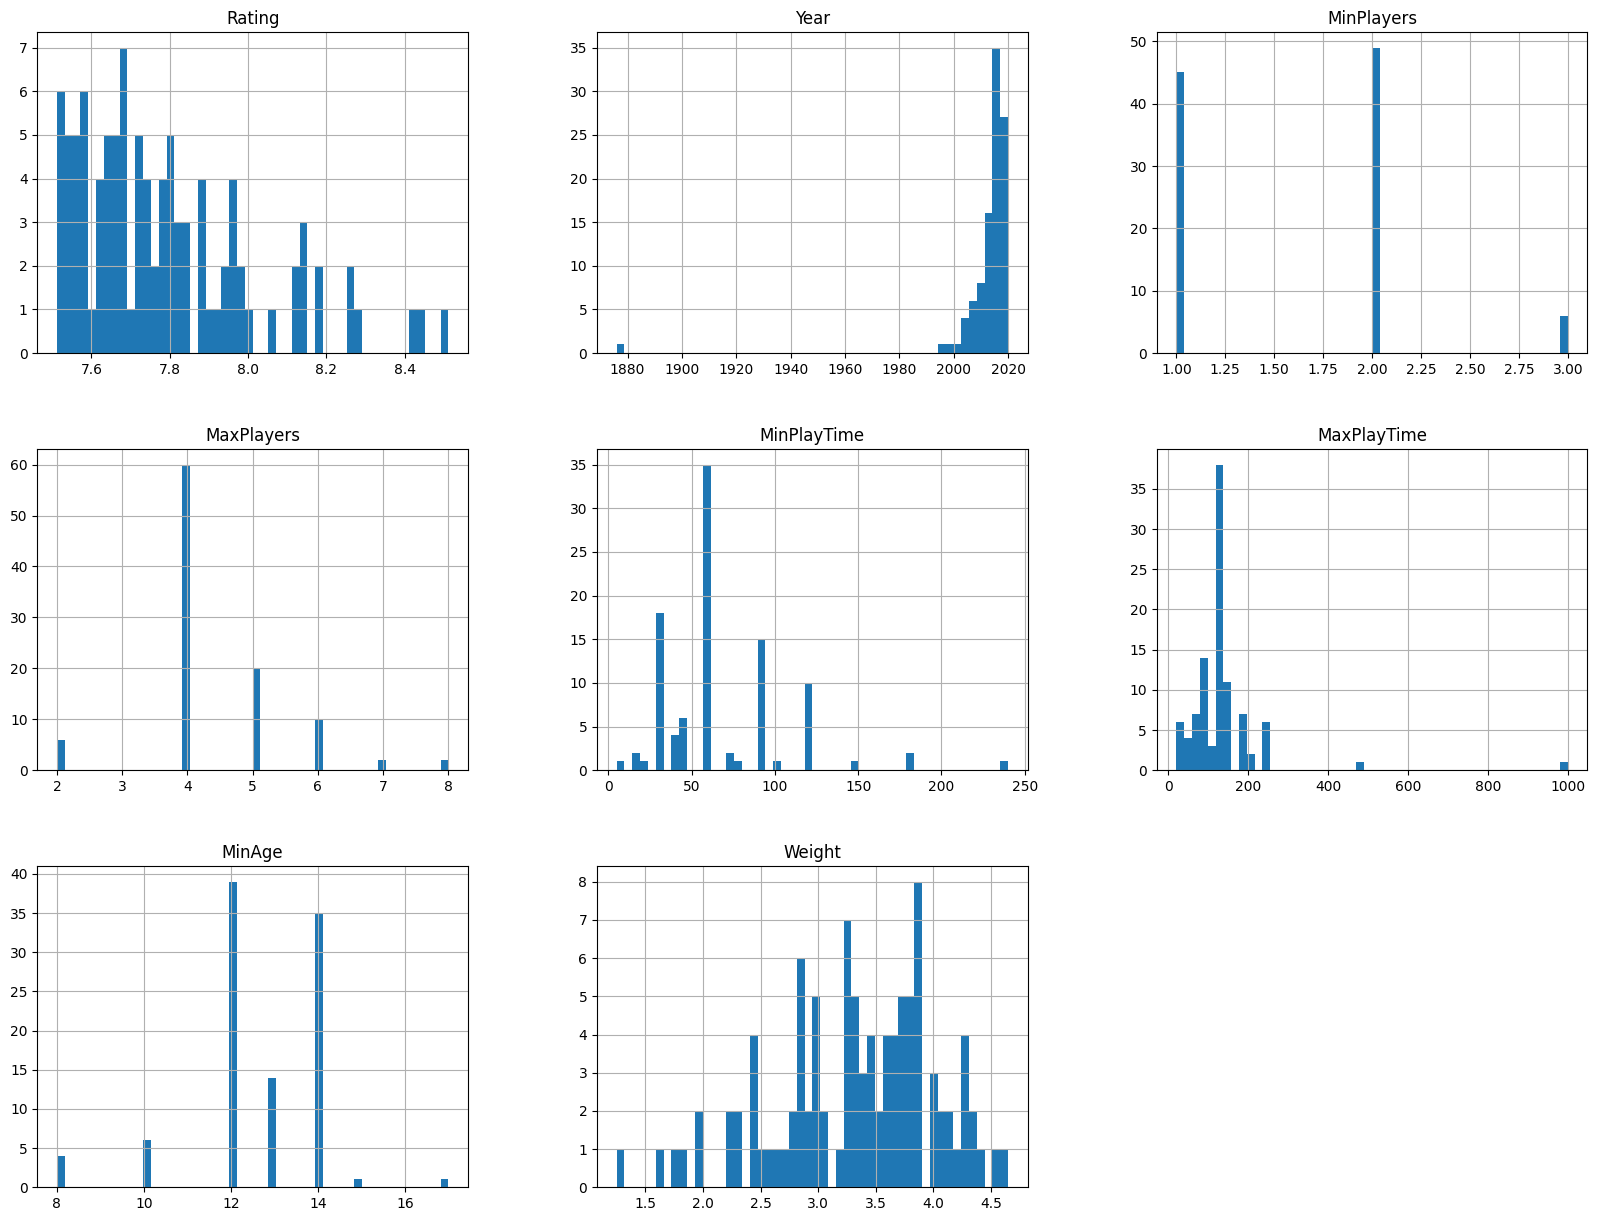

In [9]:
#distributions
df.hist(bins=50, figsize=(20,15))
plt.show()

In [40]:
#nan strings avoided
for index, value in df['BestPlayers'].items():
    if value == 'None':
        df.at[index, 'BestPlayers'] = 0

<Axes: >

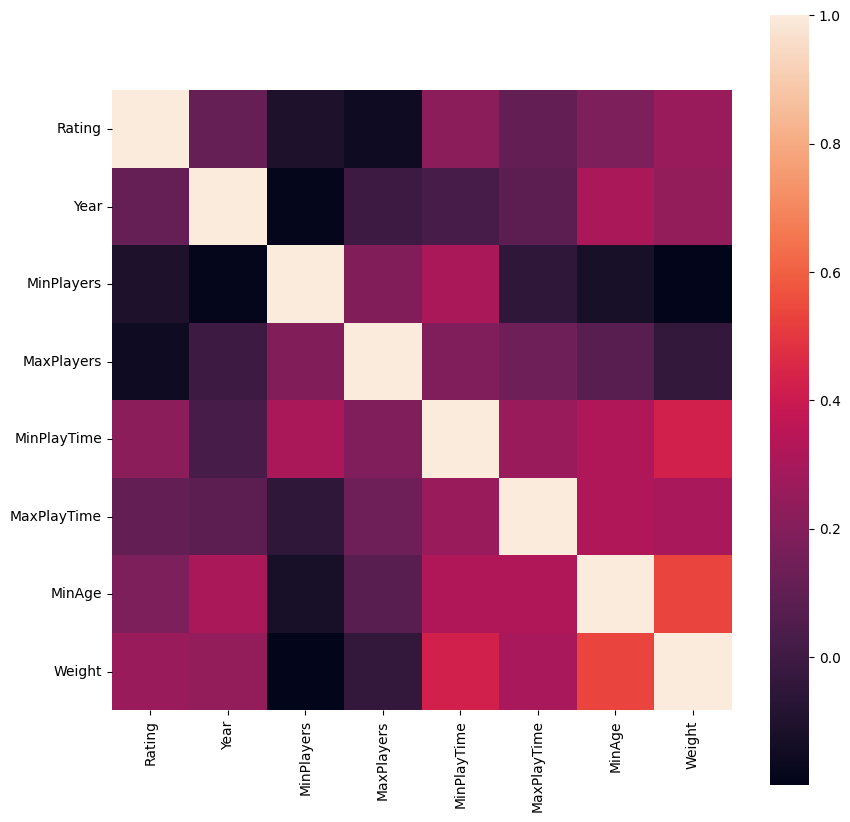

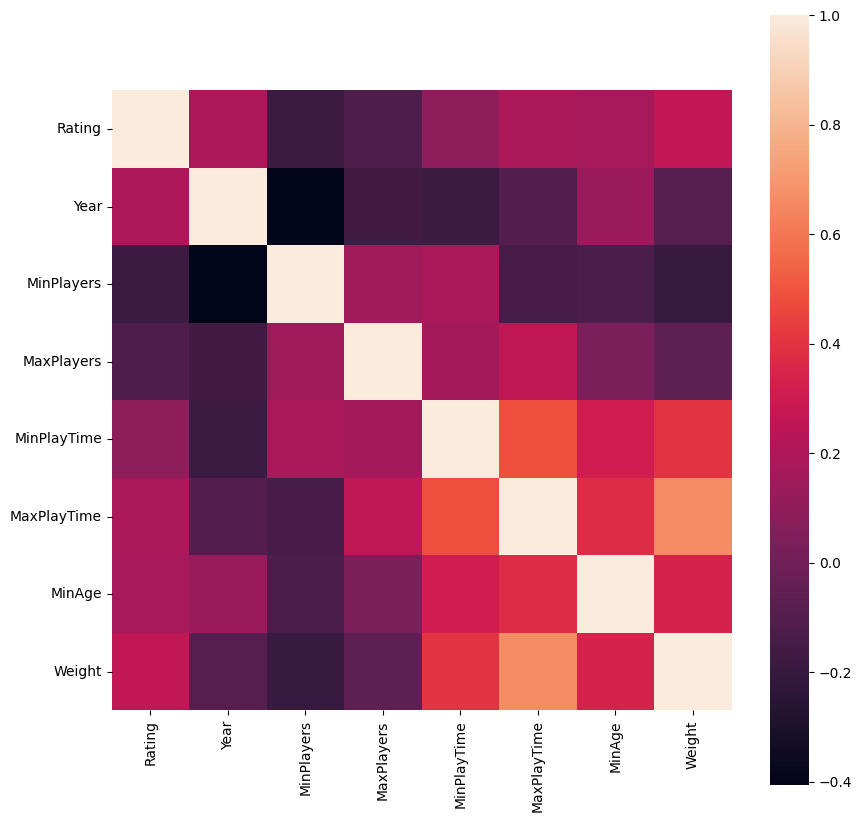

In [41]:
#correlations
df_num = df.select_dtypes(include=np.number)
column_names = df_num.columns

pearson_corrs = df_num.corr(method='pearson')
pearson_corrs_label = pearson_corrs.drop(column_names, axis = 1)
spearman_corrs = df_num.corr(method='spearman')
spearman_corrs_label = pearson_corrs.drop(column_names, axis = 1)

plt.figure(figsize=(10,10))
sns.heatmap( df_num.corr(method = 'pearson'),  square = True, fmt= '.2f',annot_kws={'size': 8})

plt.figure(figsize=(10,10))
sns.heatmap( df_num.corr(method = 'spearman'),  square = True, fmt= '.2f',annot_kws={'size': 8})


{'Strategy': 59, 'Thematic': 12, 'Strategy, Thematic': 11, 'Family, Strategy': 6, 'Family': 3, 'Strategy, Wargames': 2, 'Customizable': 2, 'Abstract, Family': 2, 'Thematic, Wargames': 1, 'Customizable, Thematic': 1, 'Party': 1}


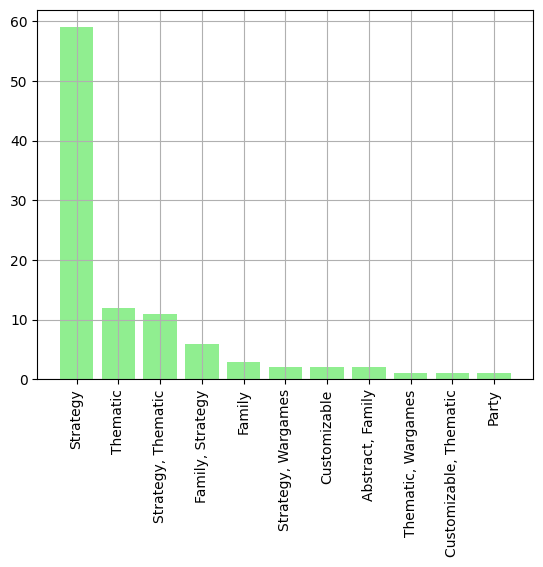

In [105]:
#discovering which types the most popular boardgames have
count_dict = df['Type'].explode().str.replace("\xa0\xa0", " ").str.replace("\xa0", " ").str.strip().value_counts().to_dict()
print(count_dict)
types = list(count_dict.keys())
number = list(count_dict.values())
plt.xticks(ticks=range(len(count_dict)), labels=types, rotation = 90)
plt.bar(range(len(count_dict)), number, color = 'lightgreen')
plt.grid()
plt.show()

In [ ]:
'''uniqueTypes = set()
for i in df['Type']:
    for k in i:
        i = k.replace("\xa0\xa0", " ").replace("\xa0", " ").strip().split(',')
        for word in i:
            w = word.strip()
            uniqueTypes.add(w)

res = list(uniqueTypes)'''

In [42]:
#dividing target variable from the other parameters
X = df_num[df_num.columns[1:12]]
y =  df_num[df_num.columns[0]]

In [70]:
# train-test split and regression models
from sklearn import svm
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lr = LogisticRegression(random_state=42)
rfr = RandomForestRegressor(random_state=42, n_estimators = 50, max_leaf_nodes=10, max_depth=3)
gbr = GradientBoostingRegressor(random_state=42, n_estimators=50, max_leaf_nodes=10, max_depth=3)
svr = svm.SVR()

In [68]:
from sklearn.metrics import r2_score
rfr.fit(X_train, y_train)
pred_rfr = rfr.predict(X_test)
print(r2_score(y_test,pred_rfr))

0.04270281457933944


In [69]:
gbr.fit(X_train, y_train)
pred_gbr = gbr.predict(X_test)
print(r2_score(y_test,pred_gbr))

-0.3874505901954097


In [71]:
svr.fit(X_train, y_train)
pred_svr = svr.predict(X_test)
print(r2_score(y_test,pred_svr))

-0.06974415843126325
